# Importing Libraries

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import date

In [2]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

In [4]:
# For resampling
from imblearn.over_sampling import SMOTE

# Loading Files

In [5]:
main_df = pd.read_csv('Prepared Frames/rated_v2.csv')

In [6]:
main_df.shape

(5396, 48)

## We drop the column that is a transformation of our target

In [7]:
print(main_df.columns)

Index(['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'tokens',
       'current_search', 'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Share Capital & Additional Paid-In Capital',
       'Retained Earnings', 'Total Equity', 'Revenue', 'Cost of Revenue',
       'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',

In [8]:
df = main_df.drop(['Investment_Grade','Rating_numbered'],axis = 1)

## We drop columns that are just noise and not relevant to our model

In [9]:
drop_columns = ['Ticker', 'SimFinId', 'Company Name','tokens',
       'current_search', 'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)','Sector', 'IndustryId', 'difflib']

In [10]:
df = df.drop(drop_columns, axis = 1)

# First Model

## X-y split

In [11]:
X = df.drop('Rating',axis = 1)
y = df['Rating']

## Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Num-Cat-Split

In [13]:
print(X.columns)

Index(['Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Share Capital & Additional Paid-In Capital',
       'Retained Earnings', 'Total Equity', 'Revenue', 'Cost of Revenue',
       'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Industry', 'interest_ratio', 'income_to_interest'],
      dtype='object'

In [14]:
# We have almost exclusively numerical columns, only the Industry column is categorical

# for column in X.columns:
#     print(column)
#     print(X[column].dtype)

In [15]:
X_train_num = X_train.select_dtypes('number')
X_test_num = X_test.select_dtypes('number')
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

## Onehot encoding

In [16]:
# Fit encoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_cat)

# Getting the column names for the later selection
column_name = encoder.get_feature_names_out(X_train_cat.columns)

# Encode train and test
train_encoded = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns = column_name, index=X_train_cat.index)
test_encoded = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns = column_name, index=X_test_cat.index)

## Scaling

In [17]:
# Fitting scaler, after trying Standard- and MinMaxScaler I saw the MinMaxScaler delivers better results.
transformer = MinMaxScaler().fit(X_train_num)

# Scaling train and test data
train_num_scaled = pd.DataFrame(transformer.transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)
test_num_scaled = pd.DataFrame(transformer.transform(X_test_num), columns = X_test_num.columns, index = X_test_num.index)

In [18]:
# Concatenating
X_train = pd.concat([train_encoded, train_num_scaled], axis = 1)
X_test = pd.concat([test_encoded,test_num_scaled], axis = 1)

In [19]:
X_test.shape

(1080, 93)

## Testing models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [21]:
# A function that I made in the Random Forest Lab to try out some models
def model_test(X_train,X_test,y_train,y_test):
    # Creating a list of different models
    modellist = [LogisticRegression(solver='sag'),
                 DecisionTreeClassifier(max_depth=7),
                 neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance'),
                 RandomForestClassifier(max_depth=7,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2,
                             n_jobs = -1),
                 ExtraTreesClassifier(n_estimators=100)
                ]
    modelnames = ['Logistic Regression','DecisionTree','KNN','RandomForest','ExtraTrees']
    #Evaluating each model
    for i in range(len(modellist)):
        model = modellist[i]
        # Fitting
        model.fit(X_train, y_train)
        # Predicting
        predictions = model.predict(X_test)
        # Calculating confusion matrix
        cm = confusion_matrix(y_test, predictions)
        print(cm)
        # Printing different evaluation metrics
        print(modelnames[i] + " score: ", model.score(X_test, y_test))
        print(modelnames[i] + " precision: ",precision_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " recall: ",recall_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " f1: ",f1_score(y_test,predictions, average = 'weighted'))

In [22]:
model_test(X_train,X_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 18   1   0   0  10  12   0   0   0   0]
 [  2   8   0   0   6   0   0   0   0   0]
 [  0   0   3   0   0   2   0   0   0   0]
 [  0   0   0 213 121   3   0   0   0   0]
 [  7   0   0 104 410   4   0   0   0   0]
 [  1   0   0  18  43  46   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0  18  11   0   0   0   0   0]
 [  0   0   0   7   4   2   0   0   0   0]]
Logistic Regression score:  0.6462962962962963
Logistic Regression precision:  0.6196873680014933
Logistic Regression recall:  0.6462962962962963
Logistic Regression f1:  0.6263421025640814
[[ 37   0   0   0   4   0   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 250  83   1   0   0   3   0]
 [  8   0   0  61 451   5   0   0   0   0]
 [  1   0   0   1  49  57   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0  11   5   0   0   0  

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN score:  0.8953703703703704
KNN precision:  0.8972327430808461
KNN recall:  0.8953703703703704
KNN f1:  0.895429913128156


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 22   0   0   0  11   8   0   0   0   0]
 [ 11   0   0   0   1   4   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0]
 [  0   0   0 232 105   0   0   0   0   0]
 [  5   0   0  55 456   9   0   0   0   0]
 [  5   0   0   0  70  33   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   2   3   0   0   0   0   0]
 [  0   0   0  24   5   0   0   0   0   0]
 [  0   0   0  10   1   2   0   0   0   0]]
RandomForest score:  0.687962962962963
RandomForest precision:  0.639741740643761
RandomForest recall:  0.687962962962963
RandomForest f1:  0.6547155579564766


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 41   0   0   0   0   0   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 324  11   0   0   0   1   1]
 [  0   0   0   9 516   0   0   0   0   0]
 [  1   0   0   0   3 104   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   5   0   0]
 [  0   0   0   5   0   0   0   0  24   0]
 [  0   0   0   2   0   0   0   1   0  10]]
ExtraTrees score:  0.9666666666666667
ExtraTrees precision:  0.965931736294537
ExtraTrees recall:  0.9666666666666667
ExtraTrees f1:  0.9660295679605869


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusion:
I am surprised to see these pretty good scores on the test data. Apparently ExtraTree and KNN classifier yield the best results.
I will try to work on that basis.

## Resampling
I will try to resample the data using SMOTE and see if we can improve the results.

In [23]:
# I had to lower the amount of neighbours to two, because of the low number of samples in the test set, sometimes it could not
# find 3 neighbors for each class.
sm = SMOTE(random_state=100, k_neighbors=2)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,y_train)

#### We retry to run our models

In [24]:
model_test(X_train_SMOTE,X_test,y_train_SMOTE,y_test)

[[ 36   2   0   0   0   3   0   0   0   0]
 [  0  16   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  6   6   0 131  58  13   0  27  76  20]
 [ 33  17   0  60 263  53   0  11  58  30]
 [  8   0   0   6   9  78   0   0   6   1]
 [  0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   5   0   0]
 [  0   0   0   1   0   4   0   7  14   3]
 [  0   0   0   0   0   0   0   1   0  12]]
Logistic Regression score:  0.5185185185185185
Logistic Regression precision:  0.6774718713368983
Logistic Regression recall:  0.5185185185185185
Logistic Regression f1:  0.5556673976884247


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 35   0   0   0   1   5   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 190  65  11   0   0  51  20]
 [ 10   0   0 138 274  75   0   0  21   7]
 [  1   1   0  12  20  73   0   0   0   1]
 [  0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   3   0   0   0   1   1   0]
 [  0   0   0   9   0   0   0   2  16   2]
 [  0   0   0   1   1   0   0   2   1   8]]
DecisionTree score:  0.5712962962962963
DecisionTree precision:  0.6362920119408407
DecisionTree recall:  0.5712962962962963
DecisionTree f1:  0.5867426870962619


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 40   0   0   0   1   0   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 296  20   1   0   3  14   3]
 [  0   0   0  45 475   4   0   0   1   0]
 [  3   0   0   2   2 101   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   5   0   0]
 [  0   0   0   5   1   1   0   0  21   1]
 [  0   0   0   1   0   0   0   1   0  11]]
KNN score:  0.8972222222222223
KNN precision:  0.9025356491431191
KNN recall:  0.8972222222222223
KNN f1:  0.8988061653696324


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 37   1   0   0   1   2   0   0   0   0]
 [  0  16   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 205  68   9   0   6  43   6]
 [ 10   0   0 101 289 114   0   0   7   4]
 [  5   0   0   1  21  81   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   5   0   0]
 [  0   0   0   3   1   1   0   4  20   0]
 [  0   0   0   2   0   1   0   2   0   8]]
RandomForest score:  0.6166666666666667
RandomForest precision:  0.6735597884752943
RandomForest recall:  0.6166666666666667
RandomForest f1:  0.6271363795117973


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 41   0   0   0   0   0   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 322  11   0   0   0   3   1]
 [  0   0   0  12 513   0   0   0   0   0]
 [  0   0   0   0   3 105   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   5   0   0]
 [  0   0   0   4   0   0   0   0  25   0]
 [  0   0   0   0   0   0   0   1   0  12]]
ExtraTrees score:  0.9657407407407408
ExtraTrees precision:  0.965359780968512
ExtraTrees recall:  0.9657407407407408
ExtraTrees f1:  0.965390471530851


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The resampling did not shift our scores in a meaningful way for the selected models. We stick with the original data.

## Feature selection

#### Taking out columns I introduced myself

In [25]:
# First i try if I can eliminate the columns I created myself earlier. Since the information is already in other columns.
Xperiment_train = X_train.drop(['interest_ratio','income_to_interest'],axis = 1)
Xperiment_test = X_test.drop(['interest_ratio','income_to_interest'],axis = 1)

In [26]:
model_test(Xperiment_train,Xperiment_test,y_train,y_test)

[[ 18   1   0   1   9  12   0   0   0   0]
 [  2   8   0   0   6   0   0   0   0   0]
 [  0   0   3   0   0   2   0   0   0   0]
 [  0   0   0 216 119   2   0   0   0   0]
 [  7   0   0 109 405   4   0   0   0   0]
 [  1   0   0  19  44  44   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0  17  12   0   0   0   0   0]
 [  0   0   0   7   4   2   0   0   0   0]]
Logistic Regression score:  0.6425925925925926
Logistic Regression precision:  0.6169388321796551
Logistic Regression recall:  0.6425925925925926
Logistic Regression f1:  0.6227213512586689


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 37   0   0   0   4   0   0   0   0   0]
 [  2  14   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 250  84   0   0   0   3   0]
 [  8   0   0  57 455   5   0   0   0   0]
 [  2   0   0   4  46  56   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   4   0   0   1   0   0]
 [  0   0   0  18   5   0   0   0   6   0]
 [  0   0   0   6   1   0   0   0   0   6]]
DecisionTree score:  0.7685185185185185
DecisionTree precision:  0.7742798562217917
DecisionTree recall:  0.7685185185185185
DecisionTree f1:  0.7590777157662052


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 41   0   0   0   0   0   0   0   0   0]
 [  2  14   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 305  22   1   0   0   7   2]
 [  0   0   0  33 491   1   0   0   0   0]
 [  6   0   0   2   5  95   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   3   1   1]
 [  0   0   0   6   1   0   0   1  21   0]
 [  0   0   0   3   2   0   0   2   0   6]]
KNN score:  0.9083333333333333
KNN precision:  0.9089461907523063
KNN recall:  0.9083333333333333
KNN f1:  0.9078135957246213


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 22   0   0   0  12   7   0   0   0   0]
 [ 11   0   0   0   3   2   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0]
 [  0   0   0 233 104   0   0   0   0   0]
 [  7   0   0  50 459   9   0   0   0   0]
 [  4   0   0   1  74  29   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   2   3   0   0   0   0   0]
 [  0   0   0  24   5   0   0   0   0   0]
 [  0   0   0  10   1   2   0   0   0   0]]
RandomForest score:  0.687962962962963
RandomForest precision:  0.6402791746103421
RandomForest recall:  0.687962962962963
RandomForest f1:  0.6527538176212179


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 41   0   0   0   0   0   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 322  15   0   0   0   0   0]
 [  0   0   0  10 515   0   0   0   0   0]
 [  3   0   0   0   3 102   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   2   0   0   3   0   0]
 [  0   0   0   4   0   0   0   0  25   0]
 [  0   0   0   2   0   0   0   1   0  10]]
ExtraTrees score:  0.9611111111111111
ExtraTrees precision:  0.9605045429884672
ExtraTrees recall:  0.9611111111111111
ExtraTrees f1:  0.9603464544937826


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# The scores did not deteriorate, so we can leave them out.
X_train = X_train.drop(['interest_ratio','income_to_interest'],axis = 1)
X_test = X_test.drop(['interest_ratio','income_to_interest'],axis = 1)

## Feature selection with KBest

In [28]:
from sklearn.feature_selection import SelectKBest , chi2
from sklearn.feature_selection import chi2

In [29]:
# First we do a quick transformation and see if we achieve anything this way
model = SelectKBest(chi2, k=35).fit(X_train, y_train)
XTr_temp = pd.DataFrame(model.transform(X_train), index = X_train.index)
Xte_temp = pd.DataFrame(model.transform(X_test), index = X_test.index)

In [30]:
model_test(XTr_temp,Xte_temp,y_train,y_test)

[[ 15   1   0   4   7  14   0   0   0   0]
 [  0   6   0   2   8   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0]
 [  3   0   0 156 176   2   0   0   0   0]
 [  0   0   0  88 433   4   0   0   0   0]
 [  0   0   0  27  44  37   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0  15  14   0   0   0   0   0]
 [  0   0   0   7   6   0   0   0   0   0]]
Logistic Regression score:  0.5990740740740741
Logistic Regression precision:  0.5701076751188037
Logistic Regression recall:  0.5990740740740741
Logistic Regression f1:  0.568979120730356
[[ 19   0   0   0   2  20   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 176 158   2   0   0   0   1]
 [  1   0   0  51 429  43   0   0   0   1]
 [  1   0   0   3  30  74   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   4   0   0   0   0   0]
 [  0   0   0   3   8   1   0   1  1

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 40   1   0   0   0   0   0   0   0   0]
 [  2  14   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 310  23   0   0   2   2   0]
 [  0   0   0  29 495   1   0   0   0   0]
 [  5   0   0   1   8  94   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   2   0   0   1   2   0]
 [  0   0   0   2   0   0   0   0  27   0]
 [  0   0   0   1   0   1   0   1   0  10]]
KNN score:  0.9222222222222223
KNN precision:  0.9221475585118876
KNN recall:  0.9222222222222223
KNN f1:  0.9214401471161549


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0   0   1  40   0   0   0   0   0]
 [  0   0   0   0  16   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0 163 174   0   0   0   0   0]
 [  0   0   0  76 449   0   0   0   0   0]
 [  0   0   0   0 108   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   2   3   0   0   0   0   0]
 [  0   0   0  19  10   0   0   0   0   0]
 [  0   0   0   6   7   0   0   0   0   0]]
RandomForest score:  0.5666666666666667
RandomForest precision:  0.4585816130077582
RandomForest recall:  0.5666666666666667
RandomForest f1:  0.4946369293442115


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 40   0   0   0   0   1   0   0   0   0]
 [  1  15   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0 318  15   1   0   0   2   1]
 [  0   0   0  15 510   0   0   0   0   0]
 [  3   0   0   0   8  97   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   1   0   0   3   0   1]
 [  0   0   0   2   1   0   0   0  26   0]
 [  0   0   0   1   0   1   0   0   0  11]]
ExtraTrees score:  0.9490740740740741
ExtraTrees precision:  0.9486937988024435
ExtraTrees recall:  0.9490740740740741
ExtraTrees f1:  0.9483914803939929


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I tried out different values for K, in almost all cases the scores deteriorated. In some cases KNN got a little better.
In this case we are better off with inspecting the columns individually and try to eliminate multicollinearity.

## Eliminating multicollinearity

In [31]:
# We concatenate X_train and y_train to see where we have correltaions with the target
df_corrcheck = pd.concat([X_train, y_train], axis=1)

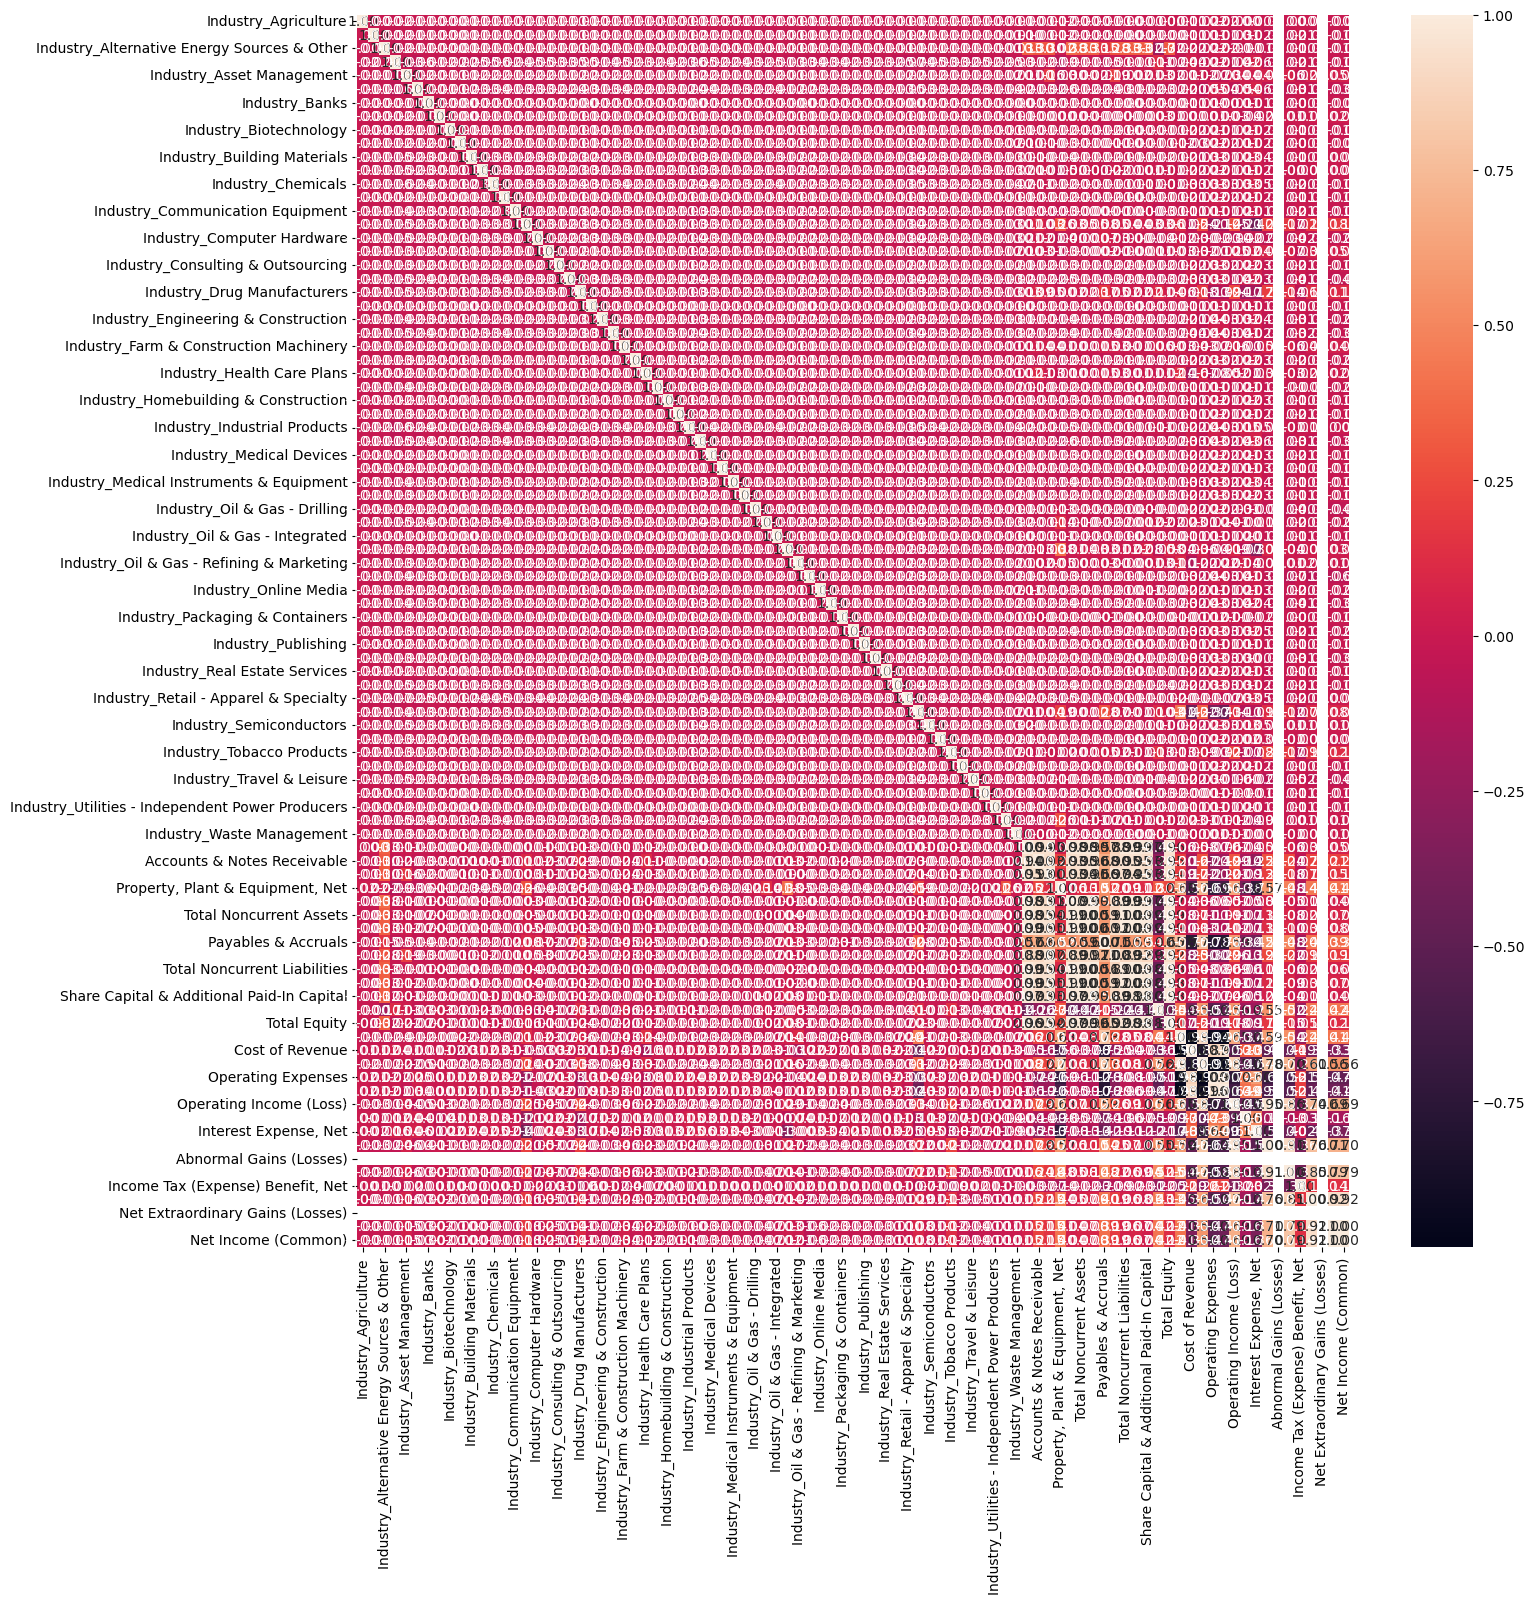

In [32]:
# creating a correlation matrix
correlations_matrix = df_corrcheck.corr()
# create a heatmap of it
plt.figure(figsize = (16,16))
sns.heatmap(correlations_matrix, annot=True, fmt='.2f')
plt.show()